CS4001/4042 Assignment 1, Part B, Q3
---

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [1]:
%pip install captum

Note: you may need to restart the kernel to use updated packages.


In [1]:
SEED = 42

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(SEED)

import warnings
from tqdm import tqdm

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from common_utils import EarlyStopper

import matplotlib.pyplot as plt

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

def set_seed(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

> First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [2]:
# TODO: Enter your code here

df = pd.read_csv('hdb_price_prediction.csv')

# Filtering data based on the year
train_df = df[df['year'] <= 2019]
validation_df = df[df['year'] == 2020]
test_df = df[df['year'] == 2021]

# Get unique values 
train_unique_years = ', '.join(map(str, train_df['year'].unique()))
validation_unique_years = ', '.join(map(str, validation_df['year'].unique()))
test_unique_years = ', '.join(map(str, test_df['year'].unique()))

# Sanity Check: Print the formatted unique values
print(f"Unique years in train_df: {train_unique_years}")
print(f"Unique years in validation_df: {validation_unique_years}")
print(f"Unique years in test_df: {test_unique_years}")

# List of numeric / continuous features
numeric_features = ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']
target_variable = 'resale_price'

# Creating X and y for train, validation and test
X_train_df = train_df[numeric_features]
y_train_df = train_df[target_variable]
train_df = train_df[numeric_features + [target_variable]]
X_val_df = validation_df[numeric_features]
y_val_df = validation_df[target_variable]
validation_df = validation_df[numeric_features + [target_variable]]
test_df = test_df[numeric_features + [target_variable]]
X_test_df = test_df[numeric_features]
y_test_df = test_df[target_variable]

# Sanity Check: Check the first few rows to confirm
display(train_df.head())
display(validation_df.head())
display(test_df.head())



Unique years in train_df: 2017, 2018, 2019
Unique years in validation_df: 2020
Unique years in test_df: 2021


,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,remaining_lease_years,floor_area_sqm,resale_price
0,1.007264,7.006044,0.016807,0.006243,61.333333,44.0,232000.0
1,1.271389,7.983837,0.016807,0.006243,60.583333,67.0,250000.0
2,1.069743,9.090700,0.016807,0.002459,62.416667,67.0,262000.0
3,0.946890,7.519889,0.016807,0.006243,62.083333,68.0,265000.0
4,1.092551,9.130489,0.016807,0.002459,62.416667,67.0,265000.0


,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,remaining_lease_years,floor_area_sqm,resale_price
64057,0.917344,7.336493,0.016807,0.006243,55.583333,73.0,265000.0
64058,0.696776,7.341622,0.016807,0.006243,91.666667,70.0,470000.0
64059,0.597608,7.292217,0.016807,0.006243,56.333333,73.0,230000.0
64060,0.994153,7.427003,0.016807,0.006243,55.250000,73.0,280000.0
64061,0.921541,8.163605,0.016807,0.006243,59.083333,68.0,220000.0


,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,remaining_lease_years,floor_area_sqm,resale_price
87370,1.276775,8.339960,0.016807,0.002459,64.083333,45.0,211000.0
87371,1.276775,8.339960,0.016807,0.002459,64.083333,45.0,225000.0
87372,0.884872,6.981730,0.016807,0.006243,59.000000,68.0,260000.0
87373,0.677246,8.333056,0.016807,0.006243,58.166667,68.0,265000.0
87374,0.922047,8.009223,0.016807,0.006243,58.083333,68.0,265000.0


> Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


Training the model...



  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [00:02<07:51,  2.37s/it]

Epoch [1/200], Training Loss: 216335745544.12698, Validation Loss: 228565798377.73914


  6%|▌         | 11/200 [00:26<07:42,  2.45s/it]

Epoch [11/200], Training Loss: 204978899756.69843, Validation Loss: 214607682515.47827


 10%|█         | 21/200 [00:52<07:51,  2.63s/it]

Epoch [21/200], Training Loss: 110174502651.93651, Validation Loss: 110820564635.82608


 16%|█▌        | 31/200 [01:21<07:59,  2.84s/it]

Epoch [31/200], Training Loss: 20880769544.126984, Validation Loss: 20614843748.173912


 20%|██        | 41/200 [01:48<06:51,  2.59s/it]

Epoch [41/200], Training Loss: 15857464222.47619, Validation Loss: 15206604043.130434


 26%|██▌       | 51/200 [02:14<06:37,  2.67s/it]

Epoch [51/200], Training Loss: 15637935851.682539, Validation Loss: 14962049380.173914


 30%|███       | 61/200 [02:38<05:18,  2.29s/it]

Epoch [61/200], Training Loss: 15370595295.492064, Validation Loss: 14707526299.826086


 36%|███▌      | 71/200 [03:01<04:53,  2.28s/it]

Epoch [71/200], Training Loss: 15025764563.301588, Validation Loss: 14422794507.130434


 40%|████      | 81/200 [03:25<04:44,  2.39s/it]

Epoch [81/200], Training Loss: 14698130415.74603, Validation Loss: 14118811158.26087


 46%|████▌     | 91/200 [03:48<04:08,  2.28s/it]

Epoch [91/200], Training Loss: 14333642784.507936, Validation Loss: 13798067867.826086


 50%|█████     | 101/200 [04:10<03:47,  2.30s/it]

Epoch [101/200], Training Loss: 13943182287.238094, Validation Loss: 13480665577.73913


 56%|█████▌    | 111/200 [04:34<03:29,  2.36s/it]

Epoch [111/200], Training Loss: 13572483624.63492, Validation Loss: 13143589554.086956


 60%|██████    | 121/200 [04:57<03:01,  2.30s/it]

Epoch [121/200], Training Loss: 13184396385.52381, Validation Loss: 12852786843.826086


 66%|██████▌   | 131/200 [05:20<02:38,  2.29s/it]

Epoch [131/200], Training Loss: 12803539561.650793, Validation Loss: 12535509348.173914


 70%|███████   | 141/200 [05:43<02:13,  2.27s/it]

Epoch [141/200], Training Loss: 12401077443.047619, Validation Loss: 12183024484.173914


 76%|███████▌  | 151/200 [06:06<01:50,  2.26s/it]

Epoch [151/200], Training Loss: 11966919241.142857, Validation Loss: 11863848514.782608


 80%|████████  | 161/200 [06:29<01:30,  2.33s/it]

Epoch [161/200], Training Loss: 11464609044.317461, Validation Loss: 11455693534.608696


 86%|████████▌ | 171/200 [06:51<01:05,  2.24s/it]

Epoch [171/200], Training Loss: 10899798731.174603, Validation Loss: 10987972808.347826


 90%|█████████ | 181/200 [07:14<00:43,  2.31s/it]

Epoch [181/200], Training Loss: 10192353572.571428, Validation Loss: 10394913235.47826


 96%|█████████▌| 191/200 [07:38<00:20,  2.31s/it]

Epoch [191/200], Training Loss: 9326468949.333334, Validation Loss: 9674623042.782608


100%|██████████| 200/200 [07:58<00:00,  2.39s/it]



Test RMSE: 116504.8046875
Test R2: 0.4868670695885562

Generating attributions for saliency...
Generating attributions for input_x_gradient...
Generating attributions for integrated_gradients...
Generating attributions for gradient_shap...
Generating attributions for feature_ablation...

Printing normalized sum attributions for 5 importance score algorithms...



,Algorithm,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,remaining_lease_years,floor_area_sqm
0,Saliency (Not Scaled),0.1545,0.1583,0.2232,0.3595,0.0351,0.0694
1,Input x Gradients (Not Scaled),-0.0127,-0.1330,0.0004,0.0002,0.2268,0.6269
2,Integrated Gradients (Not Scaled),-0.0127,-0.1330,0.0004,0.0002,0.2268,0.6269
3,GradientShap (Not Scaled),0.0025,0.2771,-0.0001,-0.0003,-0.2516,-0.4684
4,Feature Ablation (Not Scaled),-0.0127,-0.1330,0.0004,0.0002,0.2268,0.6269



======== GradientShap (Non-Standardized Features) ==========

Average Attributions for GradientShap across Test Samples:
[ 2.7702011e+02  3.0347002e+04 -8.8122025e+00 -3.2999161e+01
 -2.7552396e+04 -5.1297973e+04]
Average Convergence Delta for GradientShap across Test Samples:
0.0067897276


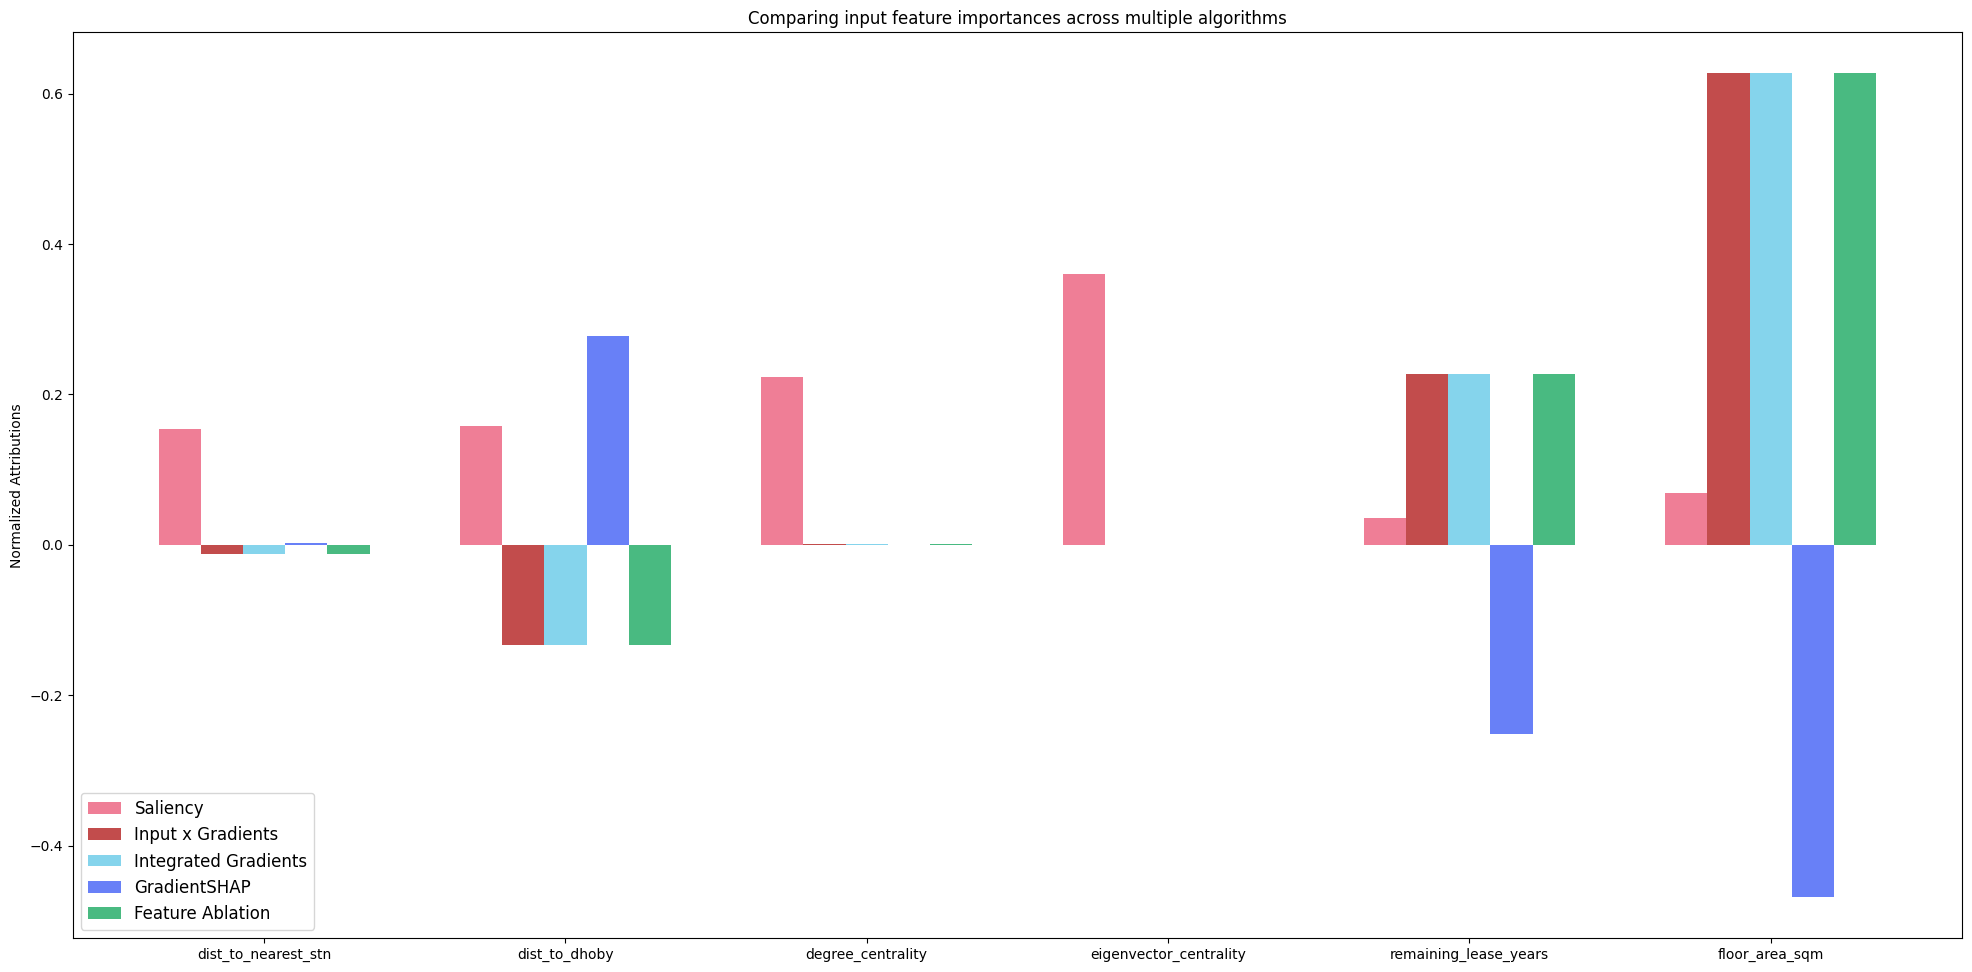

In [3]:
# TODO: Enter your code here

warnings.filterwarnings("ignore", category=UserWarning)
set_seed()

# Define Hyperparameters
batch_size = 1024 # From B1 (From Discussion Board)
num_epochs = 200 # 200 epochs, because I observed that the validation loss was still decreasing at 200 epochs, suggesting that likely no overfitting
learning_rate = 0.001

# Convert DataFrame to PyTorch tensors
X_train = torch.tensor(X_train_df.values).float()
y_train = torch.tensor(y_train_df.values).view(-1, 1).float()
X_val = torch.tensor(X_val_df.values).float()
y_val = torch.tensor(y_val_df.values).view(-1, 1).float()
X_test = torch.tensor(X_test_df.values).float()
y_test = torch.tensor(y_test_df.values).view(-1, 1).float()

# Generating train and validation DataLoaders
train_datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# Neural Network Model (Add Relu Activation Function to try to capture non-linear relationships just as shown in the tutorial from link provided)
class B3Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(len(numeric_features), 5)  
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(5, 5)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(5, 5)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(5, 1)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))

# Initialize the model
model = B3Model()

# Function to train
def train_model(model, train_iter, val_iter, num_epochs=200, learning_rate=0.001):
    # Loss and Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    early_stopper = EarlyStopper(patience=10)

    # Training Loop
    print('Training the model...', end='\n\n')
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        
        # Training Phase
        for inputs, labels in train_iter:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            avg_training_loss = running_loss / len(train_iter)
            optimizer.step()
        
        # Validation Phase (Every  epoch)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_labels in val_iter:
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
        avg_val_loss = val_loss / len(val_iter)
        
        if epoch % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_training_loss}, Validation Loss: {avg_val_loss}")
    
        # Check for early stopping
        if early_stopper.early_stop(avg_val_loss):
            print(f"Early stopping triggered at epoch {epoch}!")
            break

# Train model without scaling 
train_model(model, train_iter, val_iter, num_epochs, learning_rate)

# Test the model
model.eval()
outputs = model(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.detach().numpy(), outputs.detach().numpy()))
test_r2 = r2_score(y_test.detach().numpy(), outputs.detach().numpy())

print()
print(f"Test RMSE: {test_rmse}")
print(f"Test R2: {test_r2}", end = '\n\n')

def add_normalized_attributions(name, attributions_tensor, df):
    attributions_sum = attributions_tensor.detach().numpy().sum(0)
    normalized_attributions = attributions_sum / np.linalg.norm(attributions_sum, ord=1)
    # Append data to the dataframe
    df.loc[len(df)] = [name] + list(np.round(normalized_attributions, 4))
    return normalized_attributions

# Model explainability using Captum
saliency = Saliency(model)
input_x_gradient = InputXGradient(model)
integrated_gradients = IntegratedGradients(model)
gradient_shap = GradientShap(model)
feature_ablation = FeatureAblation(model)

# Generate attributions
print('Generating attributions for saliency...')
saliency_attr = saliency.attribute(X_test[:1000])
print('Generating attributions for input_x_gradient...')
input_x_gradient_attr = input_x_gradient.attribute(X_test[:1000])
print('Generating attributions for integrated_gradients...')
integrated_gradients_attr = integrated_gradients.attribute(X_test[:1000], n_steps=50)
print('Generating attributions for gradient_shap...')
gradient_shap_attr, delta = gradient_shap.attribute(X_test[:1000], X_train, return_convergence_delta=True)
print('Generating attributions for feature_ablation...')
feature_ablation_attr = feature_ablation.attribute(X_test[:1000])

# Prepare attributions for visualization
x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: numeric_features[idx], x_axis_data))

# Dataframe to store results
attributions_df = pd.DataFrame(columns=['Algorithm', *numeric_features])

# Normalize and add to dataframe of normalized sum of attributions
saliency_norm_sum = add_normalized_attributions("Saliency (Not Scaled)", saliency_attr, attributions_df)
input_x_gradient_norm_sum = add_normalized_attributions("Input x Gradients (Not Scaled)", input_x_gradient_attr, attributions_df)
integrated_gradients_norm_sum = add_normalized_attributions("Integrated Gradients (Not Scaled)", integrated_gradients_attr, attributions_df)
gradient_shap_norm_sum = add_normalized_attributions("GradientShap (Not Scaled)", gradient_shap_attr, attributions_df)
feature_ablation_norm_sum = add_normalized_attributions("Feature Ablation (Not Scaled)", feature_ablation_attr, attributions_df)

print('\nPrinting normalized sum attributions for 5 importance score algorithms...', end = '\n\n')
display(attributions_df)

# Print average attributions and convergence delta for GradientShap
print("\n======== GradientShap (Non-Standardized Features) ==========\n")
print("Average Attributions for GradientShap across Test Samples:")
print(np.mean(gradient_shap_attr.detach().numpy(), axis=0))
print("Average Convergence Delta for GradientShap across Test Samples:")
print(np.mean(delta.detach().numpy()))
print('===============================================================')

# Plot settings
width = 0.14
legends = ['Saliency', 'Input x Gradients', 'Integrated Gradients', 'GradientSHAP', 'Feature Ablation']

plt.figure(figsize=(20, 10))
ax = plt.subplot()

ax.set_title('Comparing input feature importances across multiple algorithms')
ax.set_ylabel('Normalized Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)
plt.rc('axes', titlesize=FONT_SIZE)
plt.rc('axes', labelsize=FONT_SIZE)
plt.rc('legend', fontsize=FONT_SIZE - 4)

# Plotting
ax.bar(x_axis_data, saliency_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, input_x_gradient_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, integrated_gradients_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gradient_shap_norm_sum, width, align='center', alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, feature_ablation_norm_sum, width, align='center', alpha=1.0, color='#49ba81')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 2 * width)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()


> Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


Training the model...



  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [00:01<05:31,  1.67s/it]

Epoch [1/200], Training Loss: 216343135508.31747, Validation Loss: 228580148624.69565


  6%|▌         | 11/200 [00:14<04:00,  1.27s/it]

Epoch [11/200], Training Loss: 216196596232.12698, Validation Loss: 228394732321.3913


 10%|█         | 21/200 [00:27<03:42,  1.24s/it]

Epoch [21/200], Training Loss: 214644147996.44446, Validation Loss: 226534063415.65216


 16%|█▌        | 31/200 [00:39<03:33,  1.26s/it]

Epoch [31/200], Training Loss: 209296447065.39682, Validation Loss: 220574552242.08694


 20%|██        | 41/200 [00:52<03:33,  1.34s/it]

Epoch [41/200], Training Loss: 198419969235.30157, Validation Loss: 208541846305.3913


 26%|██▌       | 51/200 [01:07<03:40,  1.48s/it]

Epoch [51/200], Training Loss: 181461459854.22223, Validation Loss: 189740165565.21738


 30%|███       | 61/200 [01:24<03:50,  1.66s/it]

Epoch [61/200], Training Loss: 159180339167.49207, Validation Loss: 165245641416.34784


 36%|███▌      | 71/200 [01:40<03:26,  1.60s/it]

Epoch [71/200], Training Loss: 134392578568.12698, Validation Loss: 138065537469.21738


 40%|████      | 81/200 [01:56<03:13,  1.63s/it]

Epoch [81/200], Training Loss: 111476147736.38095, Validation Loss: 112500826824.34782


 46%|████▌     | 91/200 [02:13<02:57,  1.63s/it]

Epoch [91/200], Training Loss: 93025450731.68254, Validation Loss: 91928717401.04347


 50%|█████     | 101/200 [02:29<02:39,  1.61s/it]

Epoch [101/200], Training Loss: 79522565428.8254, Validation Loss: 76965802162.08696


 56%|█████▌    | 111/200 [02:46<02:25,  1.63s/it]

Epoch [111/200], Training Loss: 70056115118.73016, Validation Loss: 66626399009.391304


 60%|██████    | 121/200 [03:02<01:50,  1.40s/it]

Epoch [121/200], Training Loss: 62422263580.44444, Validation Loss: 58734076794.434784


 66%|██████▌   | 131/200 [03:16<01:41,  1.47s/it]

Epoch [131/200], Training Loss: 55330484614.09524, Validation Loss: 51752429122.78261


 70%|███████   | 141/200 [03:33<01:39,  1.69s/it]

Epoch [141/200], Training Loss: 48077012731.93651, Validation Loss: 44814329588.86957


 76%|███████▌  | 151/200 [03:49<01:17,  1.58s/it]

Epoch [151/200], Training Loss: 40586557732.57143, Validation Loss: 37779608086.26087


 80%|████████  | 161/200 [04:07<01:12,  1.85s/it]

Epoch [161/200], Training Loss: 33357351984.761906, Validation Loss: 31201899831.652172


 86%|████████▌ | 171/200 [04:23<00:49,  1.71s/it]

Epoch [171/200], Training Loss: 26962313931.174603, Validation Loss: 25469565462.260868


 90%|█████████ | 181/200 [04:37<00:25,  1.34s/it]

Epoch [181/200], Training Loss: 21586245632.0, Validation Loss: 20733996254.608696


 96%|█████████▌| 191/200 [04:50<00:11,  1.29s/it]

Epoch [191/200], Training Loss: 17155422289.269842, Validation Loss: 16826365417.73913


100%|██████████| 200/200 [05:02<00:00,  1.51s/it]



Test RMSE: 144653.171875
Test R2: 0.20896056815817043


Generating attributions for saliency...
Generating attributions for input_x_gradient...
Generating attributions for integrated_gradients...
Generating attributions for gradient_shap...
Generating attributions for feature_ablation...

Printing normalised sum attributions for 5 importance score algorithms (Both scaled and unscaled)...



,Algorithm,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,remaining_lease_years,floor_area_sqm
0,Saliency (Not Scaled),0.1545,0.1583,0.2232,0.3595,0.0351,0.0694
1,Input x Gradients (Not Scaled),-0.0127,-0.1330,0.0004,0.0002,0.2268,0.6269
2,Integrated Gradients (Not Scaled),-0.0127,-0.1330,0.0004,0.0002,0.2268,0.6269
3,GradientShap (Not Scaled),0.0025,0.2771,-0.0001,-0.0003,-0.2516,-0.4684
4,Feature Ablation (Not Scaled),-0.0127,-0.1330,0.0004,0.0002,0.2268,0.6269
5,Saliency (Scaled),0.3394,0.0533,0.0711,0.1243,0.1458,0.2661
6,Input x Gradients (Scaled),0.3908,0.0836,0.0030,0.0173,-0.2962,-0.2092
7,Integrated Gradients (Scaled),0.1494,0.1024,-0.0100,0.0218,-0.3934,-0.3228
8,GradientShap (Scaled),-0.0945,0.0903,-0.1184,0.0011,-0.3642,-0.3315
9,Feature Ablation (Scaled),0.2435,0.0910,-0.0001,0.0191,-0.3602,-0.2861



========  GradientShap (Standardized Features) ======== 

Average Attributions for GradientShap across Test Samples:
[-15626.372    14925.021   -19569.727      187.85374 -60222.41
 -54804.105  ]
Average Convergence Delta for GradientShap across Test Samples:
1122.8002


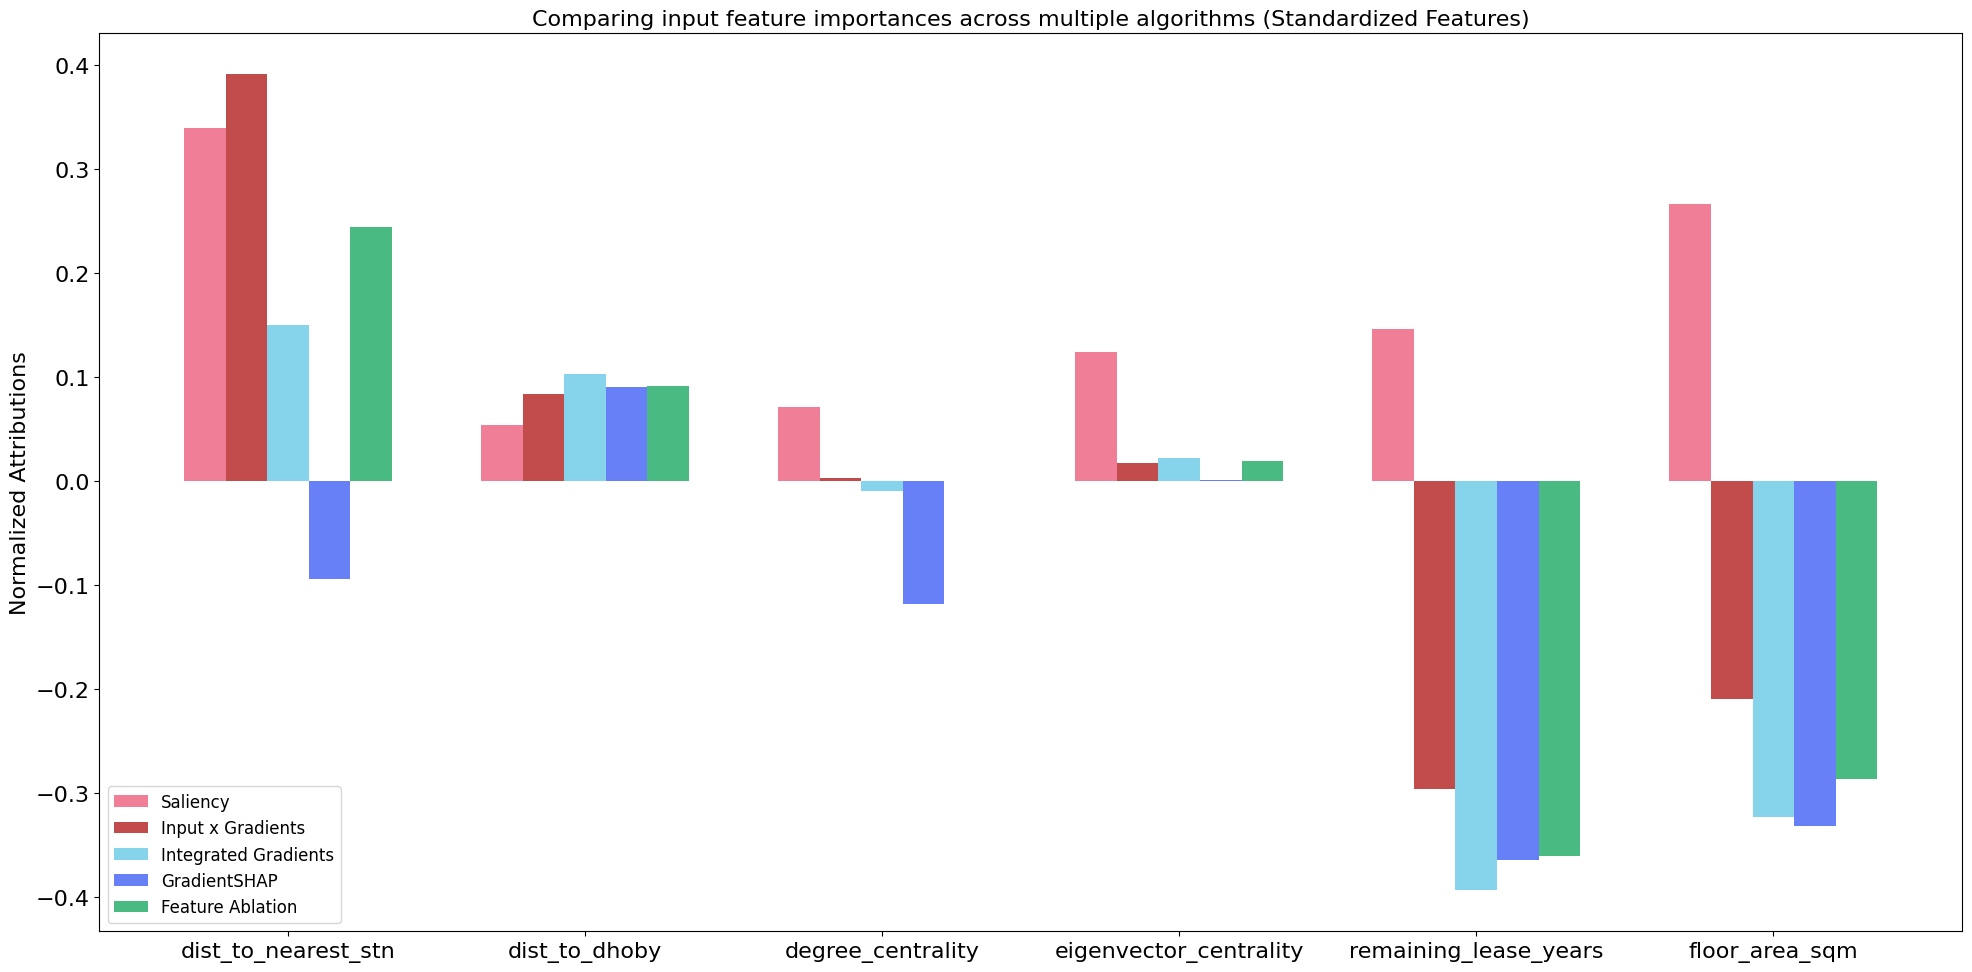

In [5]:
# TODO: Enter your code here

set_seed()
def train_model(model, train_iter, val_iter, num_epochs=200, learning_rate=0.001):
    # Loss and Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    early_stopper = EarlyStopper(patience=10)

    # Training Loop
    print('Training the model...', end='\n\n')
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        
        # Training Phase
        for inputs, labels in train_iter:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            avg_training_loss = running_loss / len(train_iter)
            optimizer.step()
        
        # Validation Phase (Every  epoch)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_labels in val_iter:
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
        avg_val_loss = val_loss / len(val_iter)
        
        if epoch % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_training_loss}, Validation Loss: {avg_val_loss}")
    
        # Check for early stopping
        if early_stopper.early_stop(avg_val_loss):
            print(f"Early stopping triggered at epoch {epoch}!")
            break


# Define Hyperparameters
batch_size = 1024 # From B1 (From Discussion Board)
num_epochs = 200 # 200 epochs, because I observed that the validation loss was still decreasing at 200 epochs, suggesting that likely no overfitting
learning_rate = 0.001

# With scaling
# Use StandardScaler to scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_val_scaled = scaler.transform(X_val_df)
X_test_scaled = scaler.transform(X_test_df)

# Convert scaled data to PyTorch tensors
X_train_scaled = torch.tensor(X_train_scaled).float()
X_val_scaled = torch.tensor(X_val_scaled).float()
X_test_scaled = torch.tensor(X_test_scaled).float()


# Generating scaled train and validation DataLoaders using scaled targets
train_datasets_scaled = torch.utils.data.TensorDataset(X_train_scaled, y_train)
train_iter_scaled = torch.utils.data.DataLoader(train_datasets_scaled, batch_size=batch_size, shuffle=True)
val_dataset_scaled = torch.utils.data.TensorDataset(X_val_scaled, y_val)
val_iter_scaled = torch.utils.data.DataLoader(val_dataset_scaled, batch_size=batch_size)

# Initialize another model for scaled data
model_scaled = B3Model()

# Train with scaled data
train_model(model_scaled, train_iter_scaled, val_iter_scaled, num_epochs, learning_rate)
model_scaled.eval()

outputs_scaled = model_scaled(X_test_scaled)

# Convert the predictions back to original scale
test_rmse_scaled = np.sqrt(mean_squared_error(y_test.detach().numpy(),outputs_scaled.detach().numpy()))
test_r2_scaled = r2_score(y_test.detach().numpy(), outputs_scaled.detach().numpy())

print()
print(f"Test RMSE: {test_rmse_scaled}")
print(f"Test R2: {test_r2_scaled}", end = '\n\n')

# Model explainability using Captum
saliency_scaled = Saliency(model_scaled)
input_x_gradient_scaled = InputXGradient(model_scaled)
integrated_gradients_scaled = IntegratedGradients(model_scaled)
gradient_shap_scaled = GradientShap(model_scaled)
feature_ablation_scaled = FeatureAblation(model_scaled)

# Generate attributions for the scaled model
print('\nGenerating attributions for saliency...')
saliency_attr_scaled = saliency_scaled.attribute(X_test_scaled[:1000])
print('Generating attributions for input_x_gradient...')
input_x_gradient_attr_scaled = input_x_gradient_scaled.attribute(X_test_scaled[:1000])
print('Generating attributions for integrated_gradients...')
integrated_gradients_attr_scaled = integrated_gradients_scaled.attribute(X_test_scaled[:1000],  n_steps=50)
print('Generating attributions for gradient_shap...')
gradient_shap_attr_scaled, delta_scaled = gradient_shap_scaled.attribute(X_test_scaled[:1000], X_train_scaled, return_convergence_delta=True)
print('Generating attributions for feature_ablation...')
feature_ablation_attr_scaled = feature_ablation_scaled.attribute(X_test_scaled[:1000])

# Normalize and store attributions
saliency_norm_sum_scaled = add_normalized_attributions("Saliency (Scaled)", saliency_attr_scaled, attributions_df)
input_x_gradient_norm_sum_scaled = add_normalized_attributions("Input x Gradients (Scaled)", input_x_gradient_attr_scaled, attributions_df)
integrated_gradients_norm_sum_scaled = add_normalized_attributions("Integrated Gradients (Scaled)", integrated_gradients_attr_scaled, attributions_df)
gradient_shap_norm_sum_scaled = add_normalized_attributions("GradientShap (Scaled)", gradient_shap_attr_scaled, attributions_df)
feature_ablation_norm_sum_scaled = add_normalized_attributions("Feature Ablation (Scaled)", feature_ablation_attr_scaled, attributions_df)

# Finally, display the DataFrame
print('\nPrinting normalised sum attributions for 5 importance score algorithms (Both scaled and unscaled)...', end = '\n\n')
display(attributions_df)

# Print average attributions and convergence delta for GradientShap
print("\n========  GradientShap (Standardized Features) ======== \n")
print("Average Attributions for GradientShap across Test Samples:")
print(np.mean(gradient_shap_attr_scaled.detach().numpy(), axis=0))
print("Average Convergence Delta for GradientShap across Test Samples:")
print(np.mean(delta_scaled.detach().numpy()))
print('===========================================================')

# Plot settings
width = 0.14
legends = ['Saliency', 'Input x Gradients', 'Integrated Gradients', 'GradientSHAP', 'Feature Ablation']

plt.figure(figsize=(20, 10))
ax = plt.subplot()

ax.set_title('Comparing input feature importances across multiple algorithms (Standardized Features)')
ax.set_ylabel('Normalized Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)
plt.rc('axes', titlesize=FONT_SIZE)
plt.rc('axes', labelsize=FONT_SIZE)
plt.rc('legend', fontsize=FONT_SIZE - 4)

# Plotting
ax.bar(x_axis_data, saliency_norm_sum_scaled, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, input_x_gradient_norm_sum_scaled, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, integrated_gradients_norm_sum_scaled, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gradient_shap_norm_sum_scaled, width, align='center', alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, feature_ablation_norm_sum_scaled, width, align='center', alpha=1.0, color='#49ba81')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 2 * width)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

# **GradientShap Analysis**

## **1. GradientSHAP Introduction**

**GradientSHAP**: It combines SHAP values with gradient-based explanations. By adding Gaussian noise to input samples, random points between baseline and input are selected. SHAP values then represent the expected gradient values multiplied by the difference between inputs and baselines.

## **2. Results Table**

### ***Normalized Sum of Attributions***

| Algorithm                              | dist_to_nearest_stn | dist_to_dhoby | degree_centrality | eigenvector_centrality | remaining_lease_years | floor_area_sqm |
|----------------------------------------|---------------------|---------------|-------------------|------------------------|-----------------------|----------------|
| GradientShap (Not Scaled)              | 0.0025              | 0.2771       | -0.0001           | -0.0003                | -0.2516               | -0.4684        |
| GradientShap (Scaled)                  | -0.0945             | 0.0903      | -0.1184           | 0.0011                 | -0.3642               | -0.3315        |

### ***GradientShap Specific Results***

| Algorithm                              | Average Attributions                                                                                              | Convergence Delta |
|----------------------------------------|--------------------------------------------------------------------------------------------------------------------|-------------------|
| GradientShap (Not Scaled)              | [ 2.7702011e+02, 3.0347002e+04, -8.8122025e+00, -3.2999161e+01, -2.7552396e+04, -5.1297973e+04]                       | 0.0067897276      |
| GradientShap (Scaled)                  | [-15626.372, 14925.021, -19569.727, 187.85374, -60222.41, -54804.105]                                              | 1122.8002         |

### **Observations**:

- After scaling, the attributions for all 6 features, `dist_to_nearest_stn`, `dist_to_dhoby`, `degree_centrality`, `eigenvector_centrality`, `remaining_lease_years`, and `floor_area_sqm` show noticeable variations.
- The convergence delta for GradientShap without scaling is 0.0067897276. However, after scaling, it increases dramatically to 1122.8002.

### **Reason for Observations**:

1. **Baseline Influence**:
   - GradientSHAP calculations are relative to a chosen baseline. For our analysis:
     - Unscaled inputs used an unscaled baseline.
     - Scaled inputs used a scaled baseline.
   - This pairing ensures the gradient contrasts between input and baseline are coherent. However, attributions still differ post-scaling due to algorithmic characteristics and model sensitivity to scaled features.

2. **Data Scaling**:
   - GradientSHAP, being an approximation technique, is sensitive to input scale. When inputs are scaled, minute variations in features can cause significant shifts in model predictions. This scaling sensitivity is evidenced by changes in attributions and the sharp rise in convergence delta.

3. **Approximation Variability**:
   - GradientSHAP introduces Gaussian noise, leading to potential variations in attributions, especially when data scaling changes.
   - Being an approximation technique, GradientSHAP can display variations especially when there's an alteration in data scaling or discrepancies in the baseline data distribution.
   - The `Convergence Delta` for GradientShap (Not Scaled) is quite low at 0.0067897276. However, upon scaling, it amplifies to 1122.8002. This significant jump emphasizes the variations introduced due to data scaling and indicates potential instability in the approximation for scaled data.
   - The convergence delta serves as a diagnostic tool to assess the quality of the approximations produced by GradientSHAP. It is defined as the difference between the sum of the attributions and the difference in the model's output for the input and the baseline. A smaller convergence delta implies that the attributions closely approximate the actual difference in model outputs, hence providing a reliable explanation. Conversely, a larger delta may suggest potential issues with the approximation's accuracy or stability.
  
## **3. Conclusion**

Scaling can significantly affect GradientSHAP attributions due to its inherent sensitivity to input transformations. The choice of baseline also plays a pivotal role in the resulting attributions. When interpreting GradientSHAP results, especially post-scaling, it's essential to consider these factors.


Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

> Why did Saliency produce scores similar to IG?


***Important Point To Note: We would be explaining why the values are different instead of why they are similar since we only used the first 1000 samples for attribution scores due to long computation times for Integrated Gradients.***

## **1. Saliency and Integrated Gradients (IG): Introduction**

### **Saliency:** 
- **Principle**: Measures the model's sensitivity to slight input variations using gradients.
- **Linearity**: Primarily captures linear relationships by evaluating local point sensitivity, potentially overlooking broader non-linear effects.

### **Integrated Gradients (IG):** 
- **Principle**: Computes attributions by integrating gradients over a path from a baseline to the input.
- **Linearity**: Can discern both linear and non-linear relationships by considering the entire attribution path.

---

## **2. Observations from the Dataset**

| Algorithm                | dist_to_nearest_stn | dist_to_dhoby | degree_centrality | eigenvector_centrality | remaining_lease_years | floor_area_sqm |
|--------------------------|---------------------|---------------|-------------------|------------------------|-----------------------|----------------|
| Saliency (Not Scaled)    | 0.1545              | 0.1583        | 0.2232            | 0.3595                 | 0.0351                | 0.0694         |
| Integrated Gradients (Not Scaled) | -0.0127          | -0.1330       | 0.0004            | 0.0002                 | 0.2268                | 0.6269         |
| Saliency (Scaled)        | 0.3394              | 0.0533        | 0.0711            | 0.1243                 | 0.1458                | 0.2661         |
| Integrated Gradients (Scaled)	| 0.1494          | 0.1024        | -0.0100           | 0.0218                 | -0.3934               | -0.3228        |

## **3. Baselines:**

- For **Integrated Gradients**, a zero scalar corresponding to each input tensor is used by default as a baseline. 
- For **Saliency**, there's no concept of a baseline. 

## **4. Detailed Explanation of Observations**

- **Path versus Point Attribution**:
Saliency's point attribution might miss broader non-linear trends, while IG's path evaluation can capture non-linear intricacies, evident in features like `degree_centrality`.

- **Handling Non-Linearities**:
Saliency, focusing on local gradients, may overlook non-linear relationships, whereas IG, considering the entire path, can capture such nuances.

- **Gradient-based Attribution Post Scaling**:
Scaling modifies gradient relationships, affecting both methods. Given Saliency's reliance on local gradients, its differences with IG become more pronounced post-scaling using the `StandardScaler`.

- **Model Simplicity**: The complexity of our model, having 5 neurons in each of its 3 hidden layers, might affect the attribution scores. A simpler model might yield more linear attributions, while a complex one might capture non-linear interactions between features and the output.

It's essential to consider that we based our analysis on the first 1000 samples. This could introduce bias or might not capture the entire variation present in the dataset, influencing the differences in scores between the two methods.

---

## **5. Conclusion**

The distinct interpretations between Saliency and IG stem from their foundational methodologies: local sensitivity (point-based) versus comprehensive path-based analysis. The HDB flat prices dataset's intricacies, paired with these methodological differences, highlight the essence of considering various feature attribution techniques for a comprehensive model interpretation.


> Why did Input x Gradients give the same attribution scores as IG?


***Important Point To Note: We would be explaining why the values are different instead of why they are similar after scaling since we only used the first 1000 samples for attribution scores due to long computation times for Integrated Gradients.***

## **1. Overview of Algorithms**

**Integrated Gradients (IG):** 
- **Principle**: Quantifies how much each feature contributed to a model's prediction relative to some baseline.
- **Linearity**: By integrating over a straight-line path from a baseline to the input, IG can capture both linear and non-linear relationships, making it versatile. 

**Input x Gradients:** 
- **Principle**: Approximates feature importance by multiplying the model’s output gradient with respect to its input by the input feature values.
- **Linearity**: Essentially measures the sensitivity of the output to changes in the input. It assumes a linear relationship over small input changes but can miss broader non-linear effects.

---

## **2. Results Table**

| Algorithm | dist_to_nearest_stn | dist_to_dhoby | degree_centrality | eigenvector_centrality | remaining_lease_years | floor_area_sqm |
|------------|----------------------|----------------|--------------------|-------------------------|-----------------------|----------------|
| Input x Gradients (Not Scaled) | -0.0127 | -0.1330 | 0.0004 | 0.0002 | 0.2268 | 0.6269 |
| Integrated Gradients (Not Scaled) | -0.0127 | -0.1330 | 0.0004 | 0.0002 | 0.2268 | 0.6269 |
| Input x Gradients (Scaled) | 0.3908 | 0.0836 | 0.0030 | 0.0173 | -0.2962 | -0.2092 |
| Integrated Gradients (Scaled) | 0.1494 | 0.1024 | -0.0100 | 0.0218 | -0.3934 | -0.3228 |

---

## **3. Baselines**

- For **Integrated Gradients**, a zero scalar corresponding to each input tensor is used by default as a baseline. 

- For **Input x Gradients**, there's no concept of a baseline. 

---

## **4. Detailed Explanation of Observations**

Given the nature of housing resale prices, both linear and non-linear relationships are expected. For instance, the increase in resale price might be linear with respect to floor area but might have a non-linear relationship with proximity to MRT stations.

#### **Before Scaling:**
- IG and Input x Gradients giving the same attribution scores suggests that for the chosen dataset, within the range of feature values, the contributions appear mostly linear, or the non-linear effects captured by IG were negligible.

#### **After Scaling (Standard Scaler):**
- Scaling essentially changes the distribution and range of the data. Differences between the algorithms post-scaling can arise due to their inherent capabilities to capture non-linearities.
- For features like `dist_to_nearest_stn`, the discrepancies between IG and Input x Gradients might stem from non-linear relationships that IG can capture over the integrated path, but Input x Gradients might miss.

---

## **5. Conclusion**

Our dataset inherently contains both linear and non-linear relationships, given the multifaceted factors affecting housing prices. While IG is designed to capture both types of relationships by integrating over a path, Input x Gradients primarily captures linear relationships over small changes. The observed similarities or differences in their results are a reflection of these inherent traits interacting with the dataset's characteristics.
